In [119]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np
import math

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH, FIGURES_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative
import experiments.utils.drawing

In [120]:
metaseries = 34
# serieses = [1, 2, 3, 4, 5]
serieses = [1, 2, 3, 5]
sla = 6.89

# serie_color = {"IPA": "#ffff99", "FA2-low": "#a1dab4", "FA2-high": "#41b6c4", "RIM-high": "#253494"}
# yellow: ffff99

series_metadata = {
    1: {"label": "IPA", "color": "#d7191c"},
    2: {"label": "FA2-low", "color": "#a1dab4"},
    3: {"label": "FA2-high", "color": "#41b6c4"},
    # 44: {"label": "RIM-low", "color": ""},
    5: {"label": "RIM", "color": "#253494"},
}
pipeline_name = "video"

series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series in serieses
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [121]:
loaders

{1: <experiments.utils.parser.AdaptationParser at 0x7f9e4cc11c10>,
 2: <experiments.utils.parser.AdaptationParser at 0x7f9e4c4f9190>,
 3: <experiments.utils.parser.AdaptationParser at 0x7f9e4b946d60>,
 5: <experiments.utils.parser.AdaptationParser at 0x7f9e4f1499d0>}

In [122]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 1 config:

{   'accuracy_method': 'multiply',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 2,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 8,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 10,
    'from_storage': [True, True],
    'gamma': 1e-06,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'logs_enabled': False,
    'lowest_model_accuracy': 0.05,
    'metadata': 'bursty - ipa - cpu type: compute_cascadelake_r_ib',
    'metaseries': 24,
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 2,
    'nodes': [   {   'cpu_request': '1',
                     'data_type': 'image',
                     'max_batch_

In [123]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [124]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{1: False, 2: False, 3: False, 5: False}

In [125]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [126]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Replica Changes
1. Total
2. Per node

In [127]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]

## Per Container Core changes
1. Total
2. Per Node

In [128]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

In [129]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()

ylabel = "Total Core"
print(total_core_changes)
print(total_core_changes.keys())

{1: {'yolo': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'resnet-human': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'total': [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.

## Accuracy Changes

In [130]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [
            sum(x) for x in zip(*accuracy_changes[series].values())
        ]
    elif accuracy_methods[series] == "multiply":
        accuracy_changes[series]["e2e"] = [
            math.prod(x) for x in zip(*accuracy_changes[series].values())
        ]    
ylabel = "Accuracy"
print(accuracy_changes)
print(accuracy_changes.keys())

{1: {'yolo': [0.457, 0.568, 0.568, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457, 0.457], 'resnet-human': [0.6975, 0.7737, 0.7737, 0.7613, 0.7613, 0.7613, 0.7613, 0.7613, 0.7613, 0.7613, 0.7613, 0.7613, 0.7613, 0.7613, 0.7613, 0.7613, 

## Maeseured p99 Latency


In [131]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

In [132]:
metric = "p99"  # [min, max, p99]
metrics_all = {}
for series in serieses:
    if not simulation_modes[series]:
        metric_columns = list(
            filter(lambda col: metric in col, per_second_results[series].columns)
        )
        metrics_all[series] = per_second_results[series][metric_columns]
        metrics_all[series] = metrics_all[series].to_dict(orient="list")
ylabel = "Second"
print(metrics_all)
print(metrics_all.keys())

{1: {'client_to_router_p99': [0.014684021472930908, 0.011010074615478515, 0.007495279312133789, 0.00899383544921875, 0.014974756240844727, 0.011150417327880859, 0.013333623409271238, 0.007824020385742187, 0.00787212371826172, 0.008382177352905274, 0.008379669189453124, 0.008802728652954101, 0.00975630760192871, 0.0133215069770813, 0.009191739559173583, 0.007591092586517334, 0.013044440746307374, 0.011808888912200928, 0.00783301591873169, 0.008348712921142578, 0.007819035053253175, 0.008670749664306641, 0.00822603702545166, 0.008118352890014648, 0.008320319652557372, 0.008281841278076171, 0.008709096908569336, 0.013650801181793211, 0.008347949981689452, 0.007592930793762207, 0.009442081451416015, 0.00812882900238037, 0.00804837942123413, 0.008096323013305665, 0.008240351676940918, 0.007801504135131836, 0.008197216987609864, 0.00847703218460083, 0.0076914381980895995, 0.007782649993896484, 0.007772493362426758, 0.008560609817504884, 0.007496380805969238, 0.007911479473114014, 0.007602558

## timeouts

In [133]:
ylabel = "% SLA Violations"
xlabel = "Experiments"
timeout_dics = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_dics[series] = {
            "e2e": (
                np.array(timeout_per_second[series]) / sum(sent_loads[series])
            ).tolist()
        }
        print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")

print(timeout_dics)
print(timeout_dics.keys())

0 out of 14437
79 out of 14437
180 out of 14437
12 out of 14437
{1: {'e2e': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

# Paper ready figures

In [134]:
import importlib
import math


METRIC_TOTAL_CORE_CHANGES = "cost"
METRIC_ACCURACY_CHANGES = "accuracy"
# METRIC_MEASURED_LATENCY = "latency"
# METRIC_TIMEOUT_DICS = "sla_violation"
SLA_VIOLATION = "sla_violation"


metrics_metadata = {
    METRIC_TOTAL_CORE_CHANGES: {
        "title": "Cost",
        "ylabel": "Cost (cores)",
    },
    METRIC_ACCURACY_CHANGES: {
        "title": "Accuracy",
        "ylabel": "Accuracy",
    },
    # METRIC_MEASURED_LATENCY: {
    #     "title": "Latency",
    #     "ylabel": "Latency (s)",
    # },
    SLA_VIOLATION: {
        "title": "SLA Violations",
        "ylabel": "SLA Violations (%)",
    },
}
results = {
    # METRIC_MEASURED_LATENCY: {},
    # METRIC_TIMEOUT_DICS: {},
    METRIC_TOTAL_CORE_CHANGES: {},
    METRIC_ACCURACY_CHANGES: {},
    SLA_VIOLATION: {},
}

# for serie in timeout_dics.keys():
#     sla_violations = list(filter(lambda x: x is not None and not math.isnan(x), timeout_dics[serie]["e2e"]))
#     results[METRIC_TIMEOUT_DICS][serie] = sum(sla_violations)/len(sla_violations)  # Fixme: Is this correct?

# for serie in metrics_all.keys():
#     latencies = list(
#         filter(
#             lambda x: x is not None and not math.isnan(x), metrics_all[serie]["e2e_p99"]
#         )
#     )
#     results[METRIC_MEASURED_LATENCY][serie] = sum(latencies) / len(latencies)

for serie in metrics_all.keys():
    latencies = list(
        filter(
            lambda x: x is not None and not math.isnan(x) and x > sla,
            metrics_all[serie]["e2e_p99"],
        )
    )
    results[SLA_VIOLATION][serie] = (
        len(latencies) / len(metrics_all[serie]["e2e_p99"]) * 100
    )

for serie in accuracy_changes.keys():
    results[METRIC_ACCURACY_CHANGES][serie] = sum(accuracy_changes[serie]["e2e"]) / len(
        accuracy_changes[serie]["e2e"]
    )

for serie in accuracy_changes.keys():
    results[METRIC_ACCURACY_CHANGES][serie] = sum(accuracy_changes[serie]["e2e"]) / len(
        accuracy_changes[serie]["e2e"]
    )

for serie in total_core_changes.keys():
    results[METRIC_TOTAL_CORE_CHANGES][serie] = sum(
        total_core_changes[serie]["total"]
    ) / len(total_core_changes[serie]["total"])


print(results)

{'cost': {1: 2.75, 2: 2.7666666666666666, 3: 5.808333333333334, 5: 6.0}, 'accuracy': {1: 0.34078278833333286, 2: 0.31875749999999964, 3: 0.4394616000000008, 5: 0.4078770275000005}, 'sla_violation': {1: 0.5833333333333334, 2: 5.583333333333333, 3: 26.166666666666664, 5: 0.75}}


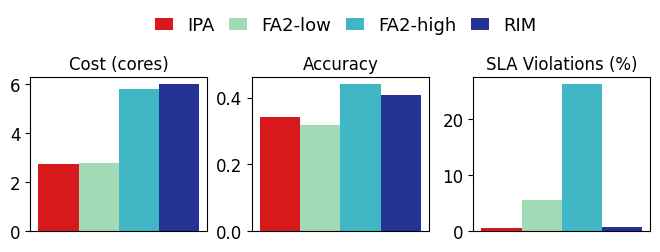

In [135]:
importlib.reload(experiments.utils.drawing)

experiments.utils.drawing.draw_cumulative_final(
    results,
    series_metadata,
    metrics_metadata,
    filename=f"{FIGURES_PATH}/metaseries-{metaseries}-{pipeline_name}-cul",
    bbox_to_anchor=(0.45, 1.5),
)